## **1) Import libraries**

In [21]:
import simpy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import math
import warnings
warnings.filterwarnings( "ignore")
from tqdm import tqdm
import time

%matplotlib inline

## **2) Simulation model**

In [22]:
N = 2
config = {'simulation_time': 24*50,   ## in hours
          'name': 'example',
          'mod': 'LDS',             ## {FIS, LDS}
          'n': N,                   ## Number of items
          'exp_number': 0,          ## Experiment number
          'cv': 0.0,                ## Demand coefficient of variation
          'alpha': 0,               ## Maximum setup increment
          'rho': 1,               ## Utilization rate
        #   'd': {i: 10 for i in range(N)},                  ## Average daily demand
          'd': {0: 10, 1: 10},                  ## Average daily demand
          #  'd': 10, 
          'k_prod': 1,            ## Capacity coefficient
          'setup0': 1,        ## Base setup time
          'cmu': 40,                ## Contribution margin per unit
          'sc': 250,                ## Setup cost
          'lc': 40,                ## Setup cost
          'hc': 0.1,                ## Daily holding cost
          'Smax': {i: 150 for i in range(N)},               ## Order-up-to level
          # 'Smin': {i: 80 for i in range(N)},                ## Reorder point  
          'Smin': {0: 100, 1: 60},                  ## Average daily demand
          # 'Smax': {i: np.random.uniform(80,150) for i in range(N)},               ## Order-up-to level
          # 'Smin': {i: np.random.uniform(30,70) for i in range(N)},                ## Reorder point  
          'initial_level': [100, 120],  ## Initial stock level; {Smax, randint, random, list any number}
          'days_year': 250,         ## Working days per year
          'random_state': 0         ## Randomness
}


In [23]:
class Factory:
    def __init__(self, env, config) -> None:
        self.env = env
        
        self.TDem = 0
        self.TSales = 0
        self.TLC = 0
        self.TSC = 0
        self.THC = 0
        self.current_prod = None

        self.d = config['d']
        self.cv = config['cv']
        self.mod = config['mod']
        self.cmu = config['cmu']
        self.lc = config['lc']
        self.sc = config['sc']
        self.hc = config['hc']
        self.rho = config['rho']
        self.n = config['n']

        self.Smax = config['Smax']
        self.Smin = config['Smin']
        self.name = config['name']
        
        self.random_state = config['random_state'] 
        self.prod_log = []
        self.current = 0
        self.idle = simpy.Event(env)
        self.df_plot = None

        self.mu = (1+config['k_prod'])*(sum(self.d.values()))*self.rho

        self.setups = self.setup_times(config['setup0'], config['alpha'] )
        self.arrival_stats = {i: [self.mu_arrival(config['d'][i], 
                                    config['random_state']*config['cv']*config['d'][i]),
                                self.sigma_arrival(config['d'][i], 
                                    config['random_state']*config['cv']*config['d'][i]),
                                    config['d'][i]] 
                                    for i in range(config['n'])}
        
        
        self.stock = self.set_initial_stock(config['initial_level'])
        self.env.process(self.monitor())
        self.set_scheduling_mode()
        self.set_calc_time()
    
    def set_initial_stock(self, mode):
        if mode == 'Smax':
            stock = {i: simpy.Container(self.env, capacity = np.inf, 
                                           init = self.Smax[i]) for i in range(self.n)}
        elif mode == 'randint':
            stock = {i: simpy.Container(self.env, capacity = np.inf, 
                                           init = np.random.randint(self.Smin[i], self.Smax[i]+1)) for i in range(self.n)}
        elif type(mode) != str:
            stock = {i: simpy.Container(self.env, capacity = np.inf, 
                                           init = mode[i]) for i in range(self.n)}
        else: 
            stock = {i: simpy.Container(self.env, capacity = np.inf, 
                                           init = np.random.uniform(self.Smin[i], self.Smax[i])) for i in range(self.n)}
        return stock

    def set_scheduling_mode(self):
        ## Set default
        if self.mod not in ['LDS', 'FIS']:
            self.mod = 'LDS'
        
        if self.mod == 'FIS':
            def schedule(self):
                self.prod_log.sort()
                product_id = self.prod_log.pop(0)
                self.current_prod = product_id
                
                return product_id
            
        if self.mod == 'LDS':
             def schedule(self):
                ## Days of Supply
                dos = [float(self.stock[i].level/self.d[i]) for i in self.prod_log]
        
                self.prod_log = [x for _, x in sorted(zip(dos, self.prod_log))]
                product_id = self.prod_log.pop(0)
                self.current_prod = product_id
                
                return product_id
        
        self.schedule_mode = schedule

    def set_calc_time(self):
        ## If Stochastic
        if self.random_state == 1:
            def time(tempo_medio):
                if tempo_medio == 0:
                    return 0
                else:
                    return np.random.lognormal(self.mu_arrival(tempo_medio, tempo_medio*self.cv),self.sigma_arrival(tempo_medio, tempo_medio*self.cv) )
                
        ## If Deterministic
        else:
            def time(tempo_medio):
                ## Returns average time
                return tempo_medio
            
        ## Sets the chosen function as an attribute of the factory
        self.calc_formula = time
        
    def calc_time(self, tempo):      
        return self.calc_formula(tempo)
    
    def select_next(self):
        return self.schedule_mode(self)
        
    def setup_times(self, setup0, alpha):
        n = self.n
        setups = np.zeros([n, n])
        for k in range(n):
            for j in range(n):
                if j < k:
                    setups[k][j] = n - 2 and (alpha + (n - 1 - k + j)*(alpha/(n-2)))*setup0 or alpha*setup0
                elif j > k:
                    setups[k][j] = n - 2 and (alpha + (j-k - 1 )*(alpha/(n-2)))*setup0 or alpha*setup0
                else:
                    setups[k][j] = 0
        return setups
        
    def mu_arrival(self, mu1, sigma1):
        if mu1>0:
            return math.log(mu1/math.sqrt(1 + (sigma1**2)/(mu1**2)))
        else:
            return 0
    
    def sigma_arrival(self, mu1, sigma1):
        if mu1 >0:
            return math.sqrt(math.log(1 + (sigma1**2)/(mu1**2)))
        else:
            return 0
           
    def monitor(self):
        self.df_plot = pd.DataFrame.from_dict(data = dict(**{'Time': self.env.now, 'Day': int(self.env.now/24)}, **{'Product ' + str(product): [self.stock[product].level] for product in range(config['n'])}))
        while True:
            yield self.env.timeout(24)
            self.df_plot = self.df_plot.append(pd.DataFrame(pd.Series(data = dict(**{'Time': self.env.now, 'Day': int(self.env.now/24)}, **{'Product ' + str(product): self.stock[product].level for product in range(config['n'])}))).T)
            self.THC += self.hc*np.sum([self.stock[i].level for i in self.stock]) 
    
    def sales(self):
        ## Starts order arrivals for each product
        for product_id in range(self.n):
            self.env.process(self.arrival(product_id))
        yield self.env.timeout(0)
            
    def get_order_qty(self, product_id):
        if self.random_state == 0:
            return self.arrival_stats[product_id][2]
        else:
            if self.arrival_stats[product_id][0] == 0:
                return 0
            else:
                return np.max([int(np.round(np.random.lognormal(self.arrival_stats[product_id][0],
                                            self.arrival_stats[product_id][1], 
                                            1),0)), 0])    

    def arrival(self, product_id):          
        
        ## Simulates order arrivals for each product 
        while True:
            
            order_qty = self.get_order_qty(product_id)

            sales_qty = np.min([self.stock[product_id].level, order_qty])
            
            # print('%.2f : Product %i - Order quantity = %i | Sold = %i | Level = %i' %(self.env.now, product_id, order_qty, sales_qty,self.stock[product_id].level ))
            if sales_qty >0:
                self.stock[product_id].get(sales_qty)
            
            if self.stock[product_id].level < self.Smin[product_id]:
                if product_id not in self.prod_log and product_id != self.current_prod:
                    
                    self.prod_log.append(product_id)
                # print('%.2f : Added product %i to production Log' %(self.env.now, product_id))
                if self.idle.triggered:
                    # print('%.2f : Already triggered' %(self.env.now))
                    pass
                else:
                    # print('%.2f : Production succeed - Product %i' %(self.env.now, product_id))
                    self.idle.succeed()
                    
            self.TSales += sales_qty
            self.TDem += order_qty
            self.TLC += (order_qty - sales_qty)*self.lc

            ## Daily demands
            yield self.env.timeout(24)
            
    def production(self):  
        while True:    
            yield self.idle
            product_id = self.select_next()

            # print('%.2f : Production started for Product %i | Level = %i' %(self.env.now, product_id, self.stock[product_id].level))
            prod_qty = self.Smax[product_id] - self.stock[product_id].level
            
            if prod_qty <0:
                print('%.2f : Production started for Product %i | Level = %i | QTY = %.2f | Smin = %.2f | Smax = %.2f' %(self.env.now, product_id, self.stock[product_id].level, prod_qty, self.Smin[product_id], self.Smax[product_id]))

            ## Setup
            time_setup = self.calc_time(self.setups[self.current][product_id])
            
            yield self.env.timeout(time_setup)
            # print('%.2f : Setup done' %(self.env.now))
            
            ## Compute setup cost
            if self.current != product_id:
                self.TSC += self.sc
            self.current = product_id
    
            ## Production
            time_produce = self.calc_time(prod_qty/self.mu*24)
            yield self.env.timeout(time_produce) ## days to hours
            self.stock[product_id].put(prod_qty)

            self.current_prod = None
            
            # print('%.2f : Product %i - Produced %i items | Level = %i' %(self.env.now, product_id, prod_qty, self.stock[product_id].level))
            

            if len(self.prod_log) == 0:
                # print('%.2f : Empty log' %(self.env.now))
                self.idle = simpy.Event(self.env)       
            else:
                # print('%.2f : Non-empty log' %(self.env.now))
                pass


In [24]:

def problem(config, print_on = False):
    env = simpy.Environment()
    factory = Factory(env, config)
    
    sales_process = env.process(factory.sales())
    production_process = env.process(factory.production())
    
    if print_on:
        print('==============')
        print('Simulation Started')
    
    env.run(config['simulation_time'])

    if print_on:
        print('Days simulated: %i' %(config['simulation_time']/24))
        print('Simulation Ended')
        print('==============')

    # Monitor inventory for the last time
    factory.df_plot = factory.df_plot.append(pd.DataFrame(pd.Series(data = dict(**{'Time': factory.env.now, 'Day': int(factory.env.now/24)}, **{'Product ' + str(product): factory.stock[product].level for product in range(config['n'])}))).T)
    factory.THC += factory.hc*np.sum([factory.stock[i].level for i in factory.stock]) 
    
    ## Compute performance indicators
    days_year = config['days_year']
    TIC = float((factory.THC + factory.TLC + factory.TSC)/((config['simulation_time']/24)/days_year))
    THC = float((factory.THC )/((config['simulation_time']/24)/days_year))
    TLC =float((factory.TLC )/((config['simulation_time']/24)/days_year))
    TSC = float((factory.TSC )/((config['simulation_time']/24)/days_year))
    SL = float(factory.TSales/factory.TDem)
    
    if print_on:
        print('Performance indicators:')
        # print('TIC: %.2f | THC: %.2f | TLC: %.2f | TSC: %.2f | SL: %.2f%%' %(TIC, THC, TLC, TSC, SL*100))
        print(f'TIC: {TIC:,.2f} \nTHC: {THC:,.2f}  | TLC: {TLC:,.2f}  | TSC: {TSC:,.2f} \n SL: {SL*100:,.2f}% ')
    return factory, {'TIC': TIC, 'THC': THC, 'TLC': TLC, 'TSC': TSC, 'SL': SL}
    
def plot_monitor(factory, indicators):
    
    fig = plt.figure(figsize=(15,5))

    
    x = np.arange(len(factory.df_plot['Day']))
    y = factory.df_plot[['Product ' + str(i) for i in range(factory.n)]]

    # Generate the reversed colors from the 'tab10' colormap
    colors = plt.cm.tab10(np.linspace(0, 1, factory.n))

    # Iterate over the columns and plot with reversed colors
    for i, column in enumerate(y.columns):
        plt.plot(x, y[column], color=colors[i], label=column, drawstyle="steps-post")
    
    if len(set(config['Smin'].values())) == 1:
        Smin = sum(config['Smin'].values())/len(config['Smin'])
        Smax = sum(config['Smax'].values())/len(config['Smax'])
        plt.axhline(y = Smin, color = 'r', linestyle = 'dashed', label ='Reorder point', alpha = 0.6)
        plt.axhline(y = Smax, color = 'black', linestyle = 'dashed', label ='Smax', alpha = 0.3)


    legend = plt.legend(loc='best', bbox_to_anchor=(1,1),
            fancybox=True, shadow=True, ncol=1)

    max_y = max(config['Smax'].values())
    plt.ylim(bottom = 0, top = max_y + 10)
    plt.title('Inventory', weight = 'bold')
    plt.xlabel('Days', weight = 'bold')
    plt.ylabel('Inventory level', weight = 'bold')

    plt.grid(axis='both', alpha=.3)

    # Remove borders
    plt.gca().spines["top"].set_alpha(0.0)    
    plt.gca().spines["bottom"].set_alpha(0.3)
    plt.gca().spines["right"].set_alpha(0.0)    
    plt.gca().spines["left"].set_alpha(0.3)

    if np.isnan(indicators['SL']):
        indicator_sl = 1
    else:
        indicator_sl = indicators['SL']
    # Create the textbox
    textbox_text = f"THC: R$ {indicators['THC']:,.2f}\nTLC: R$ {indicators['TLC']:,.2f}\nTSC: R$ {indicators['TSC']:,.2f}\n\nTIC: R$ {indicators['TIC']:,.2f}\nSL: {indicator_sl*100:.2f}%"
    textbox = plt.text(1.01,0.1, textbox_text,
                   ha='left', va='top', bbox=dict(facecolor='white', edgecolor='black'), transform=plt.gca().transAxes)


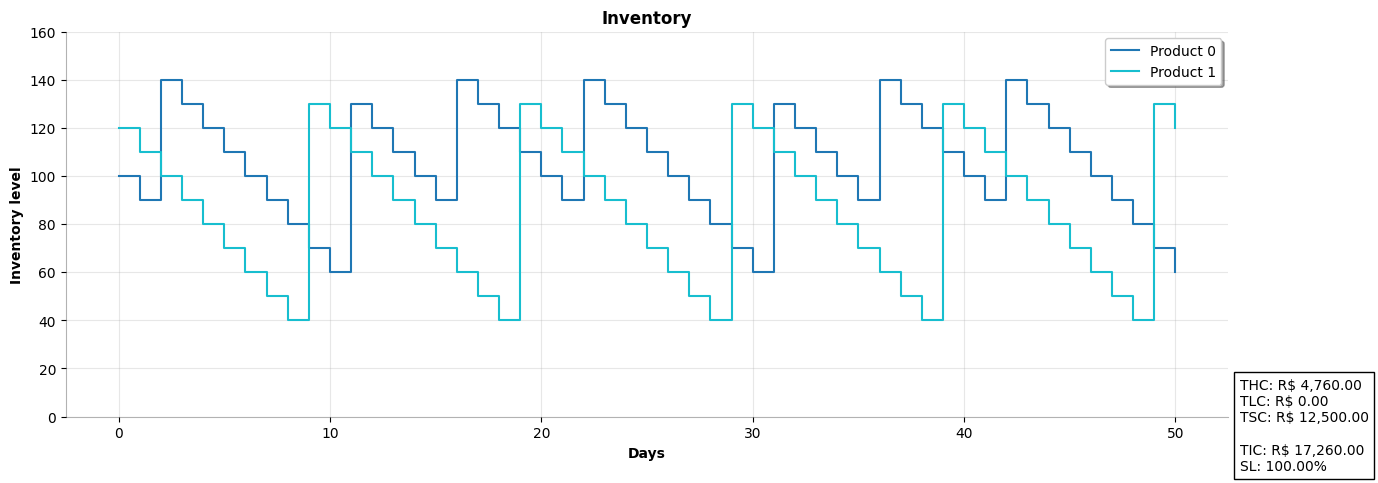

In [25]:
factory, indicators = problem(config, False)
plot_monitor(factory, indicators)

## **3) Optimization model**

In [53]:
def set_config(config, point, name):
    n = config['n']
    config_point = config
    config_point['name'] = name
    config_point['Smax'] = {i: point[:len(point)//2][i] for i in range(n)}
    config_point['Smin'] = {i: point[len(point)//2:][i] for i in range(n)}
    return config_point

def get_performance(reps, config, point, name):
    config_sim = set_config(config, point, name)
    l_cost = []
    l_sl = []
    for k in range(reps):
        _,indicators = problem(config_sim, False)
        f = indicators['TIC']
        sl = indicators['SL']
        l_cost.append(f)
        l_sl.append(sl)
    
    return np.mean(l_cost), np.mean(l_sl)

def plot_evolution_best(x_label, title, results, support_line):
    # Create a figure and axis object
    fig, ax = plt.subplots(figsize = (15,5))

    # Plot the values as a line graph
    ax.plot(results['l_best'], color = 'r', label = 'Best solution')
    
    if support_line != None :
        ax.scatter(np.arange(0,len(results['l_all']),1),results['l_all'], s = 4, alpha = 0.5, label = support_line)
        

    # Set the x and y axis labels
    ax.set_xlabel(x_label, weight = 'bold')
    ax.set_ylabel('Total Inventory Cost', weight = 'bold')

    # Set the title of the graph
    ax.set_title(title + ' (' + x_label + ' simulated = ' + str(len(results['l_best'])) + ')', weight = 'bold')
    ax.legend()
    plt.grid(axis='both', alpha=.3)

    # Remove borders
    plt.gca().spines["top"].set_alpha(0.0)    
    plt.gca().spines["bottom"].set_alpha(0.3)
    plt.gca().spines["right"].set_alpha(0.0)    
    plt.gca().spines["left"].set_alpha(0.3)

    # Show the graph
    plt.show()


In [74]:
N = 5
flags = {'N': N,
        'demand': {i: 10 for i in range(N)},
        'reps': 5,
        'cv': 0.2,                
        'rho': 1,     
        'k_prod': 0.0,
        'max_time': 5*60 , ## Max time (seconds)

        ## Random
        'n_iter_random': 1000,
        
        ## Nelder-Mead
        'Reflection_rate': 1,
        'Expansion_rate': 2,
        'Contraction_rate': 1/2,
        'Shrinkage_rate': 1/2,
        'max_iter_NM': 1000,
        'max_same_best_NM': 200,
        'tol_NM': 1,
        
        ## Genetic Algorithm
        'N_pop_GA': 20,
        'mutation_rate': 0.2,
        'N_generations': 100,
        'Survivor_rate': 0.5,
        'Blending_rate': 0.5,
        'Crossover_rate': 0.5,
        'tol_GA': 1,
        'max_same_best_GA': 20,

        ## ACO
        'N_pop_ACO': 100,
        'step': 10,
        'Influence_pheromone': 1,
        'Influence_visibility': 0,
        'Evaporation_rate': 0.1,
        'Add_pheromone': 1,
        'pheromone_0': 10,
        'method_ACO': None

        }

flags['S_ub'] = np.max(list(flags['demand'].values()))*30  ## The max stock level is the demand for 1 month of the best seller product
flags['S_lb'] = 0


config = {'simulation_time': 24*100,   ## in hours
         
         'mod': 'LDS',             ## {FIS, LDS}
         'initial_level': 'random',  ## Initial stock level
         'random_state': 1,         ## Randomness
         'name': 'default',
         'days_year': 250,         ## Working days per year
         'alpha': 0,               ## Maximum setup increment
         'setup0': 1,        ## Base setup time
         'cmu': 40,                ## Contribution margin per unit
         'sc': 250,                ## Setup cost
         'lc': 40,                ## Setup cost
         'hc': 0.1,                ## Daily holding cost
         
         'reps': flags['reps'],
         'n': flags['N'],                   ## Number of items
         'cv': flags['cv'],                ## Demand coefficient of variation
         'rho': flags['rho'],               ## Utilization rate
         'd': flags['demand'],                  ## Average daily demand
         'k_prod': flags['k_prod'],            ## Capacity coefficient
        
         'Smax': None,               ## Order-up-to level
         'Smin': None               ## Reorder point  
}


### **3.0) Random**

In [28]:
def random_opt(flags, config):

    n = flags['N']    
    
    ## Store evolution 
    l_all = []
    l_best = []
    overall_best = None
    overall_best_cost = np.inf
    overall_best_sl = 0
    count_same_best = 0

    start_time = time.time()  # Get the current time

    with tqdm(total=flags['n_iter_random'], ncols=70) as pbar:
        ## Main Loop
        for k in range(flags['max_iter_NM']):

            Smax = [np.round(flags['S_lb'] + np.random.uniform(0.0, 1.0)*( flags['S_ub'] -  flags['S_lb']),2) for i in range(n)]
            Smin = [np.random.uniform(0, Smax[i]) for i in range(n)]
            candidate = Smax + Smin 

            f, sl = get_performance(config['reps'], config, candidate, 'Random search')
            
            ## Get overall best
            if f < overall_best_cost:
                overall_best_cost = f
                overall_best = candidate
                overall_best_sl = sl
            l_best.append(overall_best_cost)
            l_all.append(f)
            
            pbar.update(1)

            elapsed_time = time.time() - start_time
            if elapsed_time >= flags['max_time']:
                break

    best_point = {'Smax': set_config(config, overall_best, 'best')['Smax'], 'Smin': set_config(config, overall_best, 'best')['Smin']}
    best_cost = overall_best_cost
    best_sl = overall_best_sl*100

    results = {'best_point': best_point, 
               'best_cost': best_cost,
               'best_sl': best_sl,
               'l_best': l_best,
               'l_all': l_all} 
    return results


In [29]:
results_rand = random_opt(flags, config)

print('Best cost : ', results_rand['best_cost'])
print('Best set : ', results_rand['best_point'])
print('Best SL : ', results_rand['best_sl'])

 43%|████████████▊                 | 429/1000 [05:00<06:40,  1.43it/s]

Best cost :  46585.47042622806
Best set :  {'Smax': {0: 260.26, 1: 264.63, 2: 271.59, 3: 115.1, 4: 238.35}, 'Smin': {0: 106.78532131767987, 1: 87.04219925540184, 2: 235.33234252792084, 3: 96.81295651086967, 4: 125.03769129335141}}
Best SL :  99.85046718638371


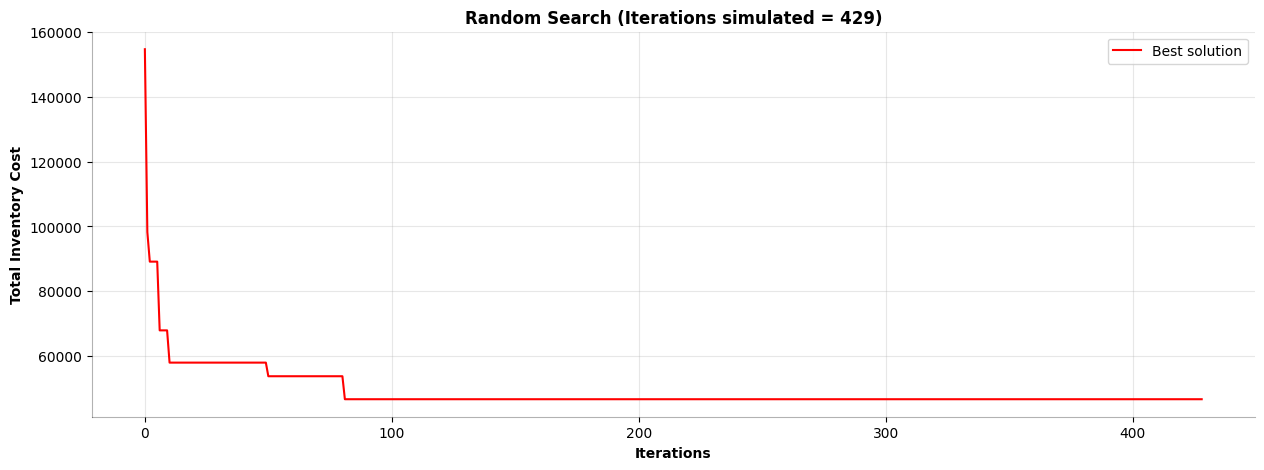

In [54]:
x_label = 'Iterations'
title = 'Random Search'
support_line = None
plot_evolution_best(x_label, title, results_rand, support_line)


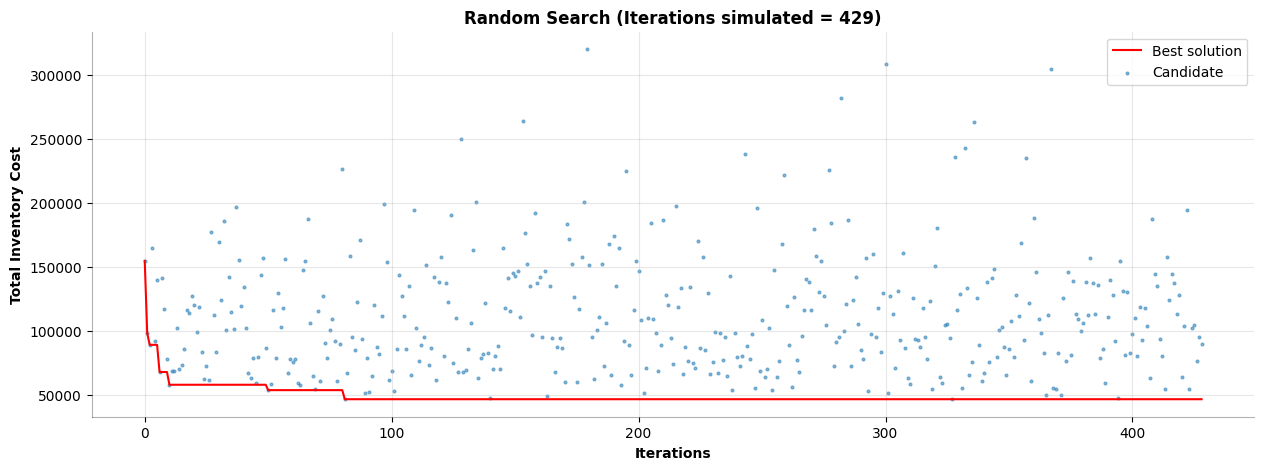

In [55]:
x_label = 'Iterations'
title = 'Random Search'
support_line = 'Candidate'
plot_evolution_best(x_label, title, results_rand, support_line)


### **3.1) Nelder-Mead**

In [35]:
def restrict(point):
    n = len(point)
    point = np.maximum(point, 0) # Enforce positive constraint
    point[n//2:] = np.minimum(point[n//2:], point[:n//2]) # Enforce additional constraint (Smax > Smin)
    
    return point

def shrink(simplex, rho, p_l, config,f_l, sl_l):
    simplex_shrink = []
    cost_shrink = []
    l_sl_shrink = []

    simplex_shrink.append(p_l)
    cost_shrink.append(f_l)
    l_sl_shrink.append(sl_l)
    
    for point in simplex[1:]:
        point_shrinked = restrict(p_l + rho*(point - p_l))
        simplex_shrink.append(point_shrinked)
        
        f_shrink, sl_shrink = get_performance(config['reps'], config, point_shrinked, 'Shrink')
        
        cost_shrink.append(f_shrink)
        l_sl_shrink.append(sl_shrink)
        
    return simplex_shrink, cost_shrink, l_sl_shrink

        
def nelder_mead(flags, config):
    # print('Nelder-Mead')
    ## Dimensions of the problem
    n = flags['N']

    ## Hyper-parameters
    alpha = flags['Reflection_rate']
    beta = flags['Expansion_rate']
    gamma = flags['Contraction_rate']
    rho = flags['Shrinkage_rate']

    ## Define the initial simplex (random)
    simplex_0 = []

    for k in range(n+1):
        Smax = [np.round(flags['S_lb'] + np.random.uniform(0.0, 1.0)*( flags['S_ub'] -  flags['S_lb']),2) for i in range(n)]
        Smin = [np.random.uniform(0, Smax[i]) for i in range(n)]
        simplex_0.append(Smax + Smin)
    
    ## Evaluate the initial simplex
    costs_simplex = []
    sl_simplex = []
    simplex = simplex_0
    for point in simplex:
        ## Add cost to list
        f, sl = get_performance(config['reps'], config, point, 'Initial simplex')
        costs_simplex.append(f)
        sl_simplex.append(sl)
        

    ## Store evolution 
    l_mean_simplex = []
    l_best = []
    overall_best = None
    overall_best_cost = np.inf
    overall_best_sl = 0
    count_same_best = 0

    start_time = time.time()  # Get the current time
    
    with tqdm(total=flags['max_iter_NM'], ncols=70) as pbar:
        ## Main Loop
        for k in range(flags['max_iter_NM']):
            
            ## Sort points by cost
            order = np.argsort(costs_simplex)
            simplex = list(np.array(simplex)[order])
            costs_simplex = list(np.array(costs_simplex)[order])
            avg_simplex = np.mean(costs_simplex)
            l_mean_simplex.append(avg_simplex)
            sl_simplex = list(np.array(sl_simplex)[order])
            
            ## Determine points with best, worst and second worst solutions (l, h, s)
            p_l, f_l, sl_l = simplex[0], costs_simplex[0], sl_simplex[0]
            p_h, f_h, sl_s = simplex[-1], costs_simplex[-1], sl_simplex[-1]
            p_s, f_s, sl_s = simplex[-2], costs_simplex[-2], sl_simplex[-2]
            
            ## Get overall best
            if f_l < overall_best_cost:
                overall_best_cost = f_l
                overall_best = p_l
                overall_best_sl = sl_l
                count_same_best = 0
            else:
                count_same_best += 1
            l_best.append(overall_best_cost)
                
            ## Compute the centroid (without P_h)
            centroid = np.mean(simplex[:-1], axis=0)

            ## Reflection
            p_r = restrict(centroid + alpha*(centroid - p_h))
            f_r, sl_r = get_performance(config['reps'], config, p_r, 'Reflexion')
            
            ## Case 1
            if f_l <= f_r <f_s:
                simplex[-1] = p_r
                costs_simplex[-1] = f_r
                sl_simplex[-1] = sl_r

            ## Case 2
            elif f_r < f_l:
                ## Expansion
                p_e = restrict(centroid + beta*(p_r - centroid))
                # print('P_e: ', p_e)
                f_e, sl_e = get_performance(config['reps'], config, p_e, 'Expansion')

                ## Case 2.1
                if f_e < f_r:
                    simplex[-1] = p_e
                    costs_simplex[-1] = f_e
                    sl_simplex[-1] = sl_e
                ## Case 2.2
                else:
                    simplex[-1] = p_r
                    costs_simplex[-1] = f_r
                    sl_simplex[-1] = sl_r
            
            ## Case 3
            else:
                ## Contraction
                p_c = restrict(centroid + gamma*(p_h - centroid))
                f_c, sl_c = get_performance(config['reps'], config, p_c, 'Contraction')

                ## Caso 3.1
                if f_c < f_h:
                    simplex[-1] = p_c
                    costs_simplex[-1] = f_c
                    sl_simplex[-1] = sl_c

                ## Caso 3.2
                else:
                    ## Shrinkage
                    simplex, costs_simplex, sl_simplex = shrink(simplex, rho, p_l, config, f_l, sl_l)
                    
            
            ## Check if conditions satisfied
            if np.max(np.abs(np.array(costs_simplex) - costs_simplex[0])) <= flags['tol_NM'] or count_same_best >= flags['max_same_best_NM']:
                break
            
            pbar.update(1)

            elapsed_time = time.time() - start_time
            if elapsed_time >= flags['max_time']:
                break


    best_point = {'Smax': set_config(config, overall_best, 'best')['Smax'], 'Smin': set_config(config, overall_best, 'best')['Smin']}
    best_cost = overall_best_cost
    best_sl = overall_best_sl*100

    results = {'best_point': best_point, 
               'best_cost': best_cost,
               'best_sl': best_sl,
               'l_best': l_best,
               'l_all': l_mean_simplex} 

    return results



In [36]:
results_nm = nelder_mead(flags, config)
print('Best cost : ', results_nm['best_cost'])
print('Best set : ', results_nm['best_point'])
print('Best SL : ', results_nm['best_sl'])

Nelder-Mead


 16%|████▉                         | 163/1000 [05:02<25:55,  1.86s/it]

Best cost :  39639.189242340544
Best set :  {'Smax': {0: 180.8934278047717, 1: 183.17813205955787, 2: 133.60208100246922, 3: 195.49172757712157, 4: 180.56989766646885}, 'Smin': {0: 117.7193398030426, 1: 70.32634332145122, 2: 54.6601001311723, 3: 83.22140746845596, 4: 127.31665589316827}}
Best SL :  99.69909303927994


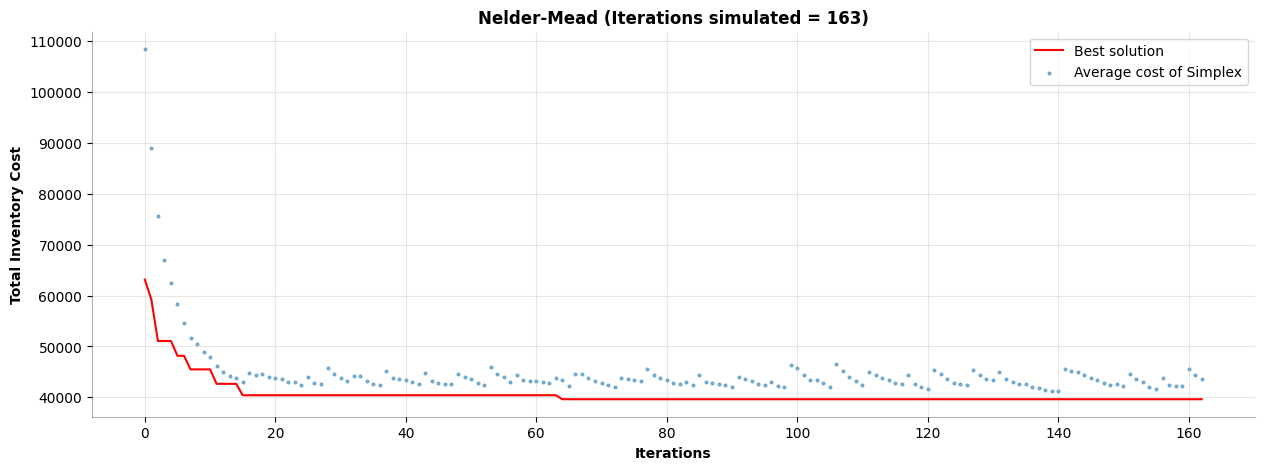

In [56]:
x_label = 'Iterations'
title = 'Nelder-Mead'
support_line = 'Average cost of Simplex'
plot_evolution_best(x_label, title, results_nm, support_line)


### **3.2) Genetic Algorithm**

In [75]:
def init_pop(flags):
    population = []
    
    for k in range(flags['N_pop_GA']):
        Smax = [np.round(flags['S_lb'] + np.random.uniform(0.0, 1.0)*( flags['S_ub'] -  flags['S_lb']),2) for i in range(flags['N'])]
        Smin = [np.random.uniform(0, Smax[i]) for i in range(flags['N'])]
        ## Add chromosome to population
        population.append(Smax + Smin)
    
    return population

def selection(cost_population, sl_population, population, N_keep):

    ## Select best
    parents = population[:N_keep]
    cost_parents = cost_population[:N_keep]
    sl_parents = sl_population[:N_keep]
    
    return parents, cost_parents, sl_parents

def crossover(beta, parents,flags, N_crossover_points, N_offspring):
    
    l_offspring = []
    
    while len(l_offspring) < (N_offspring):
        ## Random choice of parents
        random_couple = np.random.choice(len(parents),2, replace= False)
        father = random_couple[0]
        mother = random_couple[1]
        offspring = parents[father].copy()

        ## Ramdomly select crossover points
        for point in np.random.choice(flags['N'],N_crossover_points, replace=False):
            offspring[point] = beta*parents[father][point] + (1-beta)*parents[mother][point]

        l_offspring.append(restrict(offspring))
    
    return l_offspring

def mutation(l_offspring, tau, flags):
    for offspring in l_offspring:
        mutations = [i for i in range(flags['N']) if np.random.random() < tau]
        for gene in mutations:
            if gene < flags['N']:  ## i.e. Smax
                lb = offspring[gene + flags['N']]
                offspring[gene] = np.round(lb + np.random.uniform(0.0, 1.0)*( flags['S_ub'] -  lb),2)
            else:  ## i.e. Smin
                ub = offspring[gene - flags['N']]
                offspring[gene] = np.round(flags['S_lb'] + np.random.uniform(0.0, 1.0)*( ub -  flags['S_lb']),2)

    return l_offspring

def population_cost(population):
    cost_population = []
    sl_population = []

    for individual in population:
        f, sl = get_performance(config['reps'], config, individual, 'Default')
        cost_population.append(f)
        sl_population.append(sl)

    ## Sort points by cost
    order = np.argsort(cost_population)
    population = list(np.array(population)[order])
    cost_population = list(np.array(cost_population)[order])
    sl_population = list(np.array(sl_population)[order])

    return cost_population, sl_population
    


def genetic_algorithm(flags, config):

    beta = flags['Blending_rate']
    tau = flags['mutation_rate']
    N_pop = flags['N_pop_GA']
    N_keep = int(np.round(N_pop*flags['Survivor_rate'],0))
    N_offspring = N_pop - N_keep
    N_crossover_points = int(flags['N']*flags['Crossover_rate'])
    N_generations = flags['N_generations']

    population = init_pop(flags)
    new_gen = population.copy()

    # print(N_pop, N_keep, N_offspring)
    
    ## Store evolution 
    l_best = []
    overall_best = None
    overall_best_cost = np.inf
    overall_best_sl = 0
    count_same_best = 0
    l_mean_pop = []
    
    start_time = time.time()  # Get the current time
    
    with tqdm(total=N_generations, ncols=70) as pbar:
        ## Main Loop
        for k in range(N_generations):

            population = new_gen.copy()

            cost_population, sl_population = population_cost(population)
            avg_pop = np.mean(cost_population)
            l_mean_pop.append(avg_pop)
            
            parents, cost_parents, sl_parents = selection(cost_population,sl_population, population, N_keep)
            l_offspring = crossover(beta, parents,flags, N_crossover_points, N_offspring)
            l_offspring = mutation(l_offspring, tau, flags)

            new_gen = parents + l_offspring


            ## Get overall best
            if cost_population[0] < overall_best_cost:
                overall_best_cost = cost_population[0]
                overall_best = population[0]
                overall_best_sl = sl_population[0]
                count_same_best = 0
            else:
                count_same_best += 1
            l_best.append(overall_best_cost)

            

            ## Check if conditions satisfied
            if np.max(np.abs(np.array(cost_population) - cost_population[0])) <= flags['tol_GA'] or count_same_best >= flags['max_same_best_GA']:
                # print(cost_population)
                # print(np.max(np.abs(np.array(cost_population) - cost_population[0])))
                # print('Stopped by max tolerance')
                break
    
            pbar.update(1)

            elapsed_time = time.time() - start_time
            if elapsed_time >= flags['max_time']:
                print('Stopped by max time')
                break
    
   
    best_point = {'Smax': set_config(config, overall_best, 'best')['Smax'], 'Smin': set_config(config, overall_best, 'best')['Smin']}
    best_cost = overall_best_cost
    best_sl = overall_best_sl*100

    results = {'best_point': best_point, 
               'best_cost': best_cost,
               'best_sl': best_sl,
               'l_best': l_best,
               'l_all': l_mean_pop} 

    return results
    

In [76]:
results_ga = genetic_algorithm(flags, config)
print('Best cost : ', results_ga['best_cost'])
print('Best set : ', results_ga['best_point'])
print('Best SL : ', results_ga['best_sl'])

 21%|██████▋                         | 21/100 [05:01<18:54, 14.37s/it]

Stopped by max time
Best cost :  43419.53910193533
Best set :  {'Smax': {0: 58.94, 1: 173.41, 2: 47.05, 3: 171.35, 4: 202.99}, 'Smin': {0: 46.79343871973844, 1: 18.732255979686112, 2: 0.8747269770711132, 3: 138.24111506100985, 4: 14.808492368123161}}
Best SL :  99.4986645600541


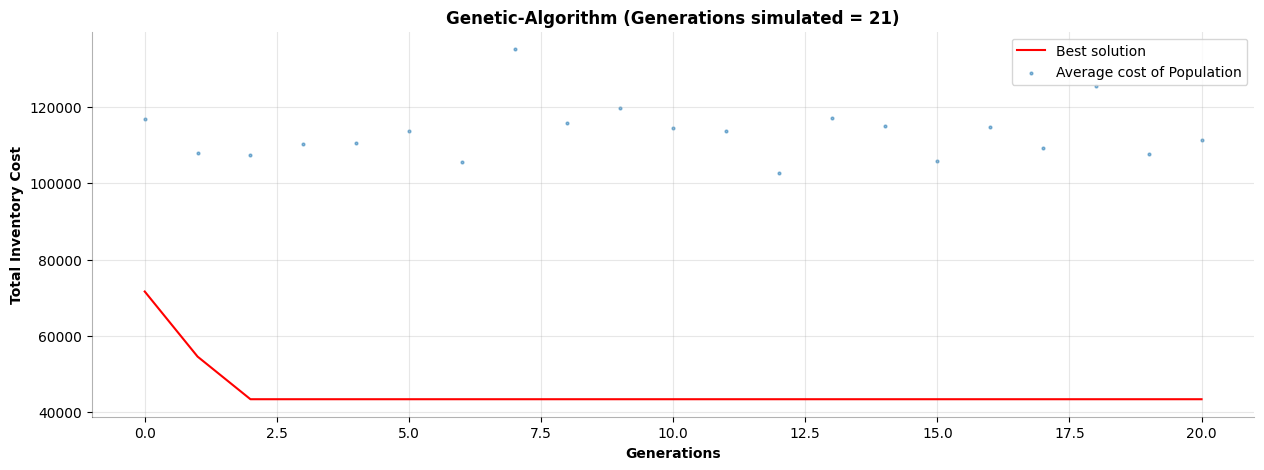

In [77]:
x_label = 'Generations'
title = 'Genetic-Algorithm'
support_line = 'Average cost of Population'
plot_evolution_best(x_label, title, results_ga, support_line)


### **3.3) Ant Colony**

In [154]:
import os
import networkx as nx

class AntColony():

    def __init__(self, flags, config):
        self.alpha = flags['Influence_pheromone']
        self.beta = flags['Influence_visibility']
        self.rho = flags['Evaporation_rate']
        self.Q = flags['Add_pheromone']
        self.nb_ant = flags['N_pop_ACO']
        self.tau_0 = flags['pheromone_0']
        self.method = flags['method_ACO']
        self.basic_config = config

        self.levels = self.define_levels(flags)
        self.graph = self.__init_graph()
        

    def __init_graph(self):
        """ Initialize the graph """
        graph = nx.DiGraph()
        # Initialisation des noeuds
        for level, choices in self.levels:
            for choice in choices:
                graph.add_node((level, choice), level=level)
        # Initialisation des liens
        for (name_i, choices_i), (name_j, choices_j) in zip(self.levels, self.levels[1:]):
            for choice_i in choices_i:
                for choice_j in choices_j:
                    graph.add_edge((name_i, choice_i),
                                   (name_j, choice_j), tau=1, nu=1)
        print(graph)
        return graph
    
    def define_levels(self, flags):
        levels = [("init", ["init"])]

        for k in range(flags['N']):
            for var in ['Smax', 'Smin']:
                l_range = np.arange(flags['S_lb'],flags['S_ub'] + flags['step'], flags['step'])
                level_name = var + '_' + str(k)
                levels.append((level_name, l_range))
        
        return levels
    
    def plot_graph(self):
        """ Show the graph """

        fig = plt.figure(figsize=(5,5))
        # Set the layout of the graph as a tree
        pos = nx.drawing.nx_agraph.graphviz_layout(self.graph, prog='dot', root="init")

        # # Draw the graph as a tree
        # nx.draw(self.graph, pos, with_labels=True, arrows=True,edge_cmap=plt.cm.OrRd, labels={node: node[1] for node in self.graph.nodes})

        # Set node and edge colors
        node_labels = {node: node[1] for node in self.graph.nodes}
        node_colors = ['lightblue' for _ in self.graph.nodes]
        edge_colors = [self.graph.edges[edge]['tau'] for edge in self.graph.edges]

        # Draw the graph as a tree with improved contrast and adjusted fontsize
        nx.draw(self.graph, pos, with_labels=True, node_color=node_colors, edge_color=edge_colors, edge_cmap=plt.cm.OrRd, labels=node_labels,
                font_size=8, node_size=500, font_color='black', font_weight='bold')
        
        # Set the darker color for edges
        edges = nx.draw_networkx_edges(self.graph, pos, alpha=0.3, edge_color='red')

        # Add layer descriptions in bold
        layer_descriptions = {level: f"{level}" for level, _ in self.levels}
        max_x = max(pos[node][0] for node in self.graph.nodes)
        for level in layer_descriptions:
            y = [pos[node][1] for node in self.graph.nodes if node[0] == level]
            plt.text(-0.1 * max_x, y[0], layer_descriptions[level], ha='right', va='center', fontweight='bold')

        # Show the plot
        plt.show()

    def plot_2(self):
        # Set the layout of the graph as a tree
        pos = nx.drawing.nx_agraph.graphviz_layout(self.graph, prog='dot', root="init")

        # Create a new subgraph with limited nodes per layer
        max_nodes_per_layer = 10

        subgraph = nx.DiGraph()
        for level, choices in self.levels:
            chosen_nodes = choices[:max_nodes_per_layer]
            if len(choices) > max_nodes_per_layer:
                chosen_nodes = np.concatenate((chosen_nodes, np.array([choices[-1]])))
            for choice in chosen_nodes:
                subgraph.add_node((level, choice), level=level)

        # Add the corresponding edges to the subgraph
        for edge in self.graph.edges():
            if edge[0] in subgraph.nodes() and edge[1] in subgraph.nodes():
                subgraph.add_edge(edge[0], edge[1])

        # Set node and edge colors
        node_labels = {node: node[1] for node in subgraph.nodes}
        node_colors = ['lightblue' for _ in subgraph.nodes]
        edge_colors = [self.graph.edges[edge]['tau'] for edge in subgraph.edges()]

        # Manually adjust the position of the first layer nodes for centering
        first_layer_nodes = [node for node in subgraph.nodes if node[0] == 0]
        if first_layer_nodes:
            first_layer_y = [pos[node][1] for node in first_layer_nodes]
            avg_y = sum(first_layer_y) / len(first_layer_y)

            other_layers_x = set()
            for node in subgraph.nodes:
                if node[0] != 0:
                    other_layers_x.add(pos[node][0])
            avg_x = sum(other_layers_x) / len(other_layers_x)

            for node in first_layer_nodes:
                pos[node] = (avg_x, avg_y)

        # Draw the subgraph as a tree with limited nodes per layer
        nx.draw(subgraph, pos, with_labels=True, node_color=node_colors, edge_color='red', edge_cmap=plt.cm.Reds, labels=node_labels,
                font_size=8, node_size=500, font_color='black', font_weight='bold')

        # Add layer descriptions in bold
        layer_descriptions = {level: f"Layer {level}" for level, _ in self.levels}
        max_x = max(pos[node][0] for node in subgraph.nodes)
        for level in layer_descriptions:
            nodes_in_layer = [node for node in subgraph.nodes if node[0] == level]
            if nodes_in_layer:
                y = pos[nodes_in_layer[0]][1]
                plt.text(-0.1 * max_x, y, layer_descriptions[level], ha='right', va='center', fontweight='bold')

        # Show the plot
        plt.show()




DiGraph with 125 nodes and 2914 edges


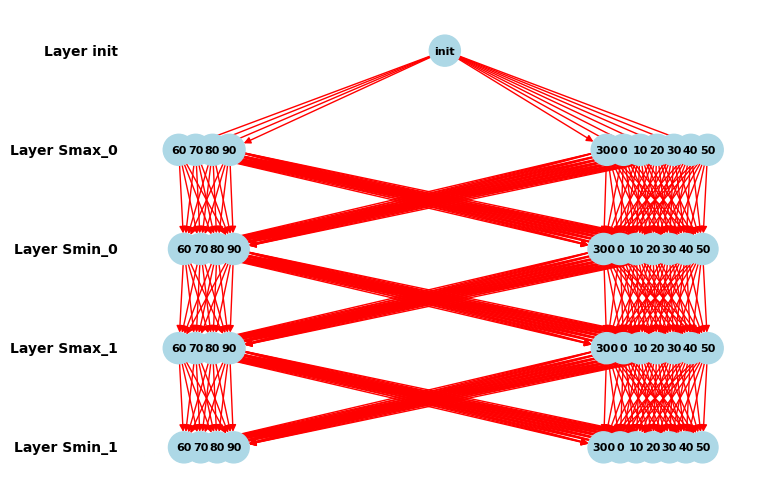

In [155]:
ant_colony = AntColony(flags, config)
ant_colony.plot_2()

DiGraph with 125 nodes and 2914 edges


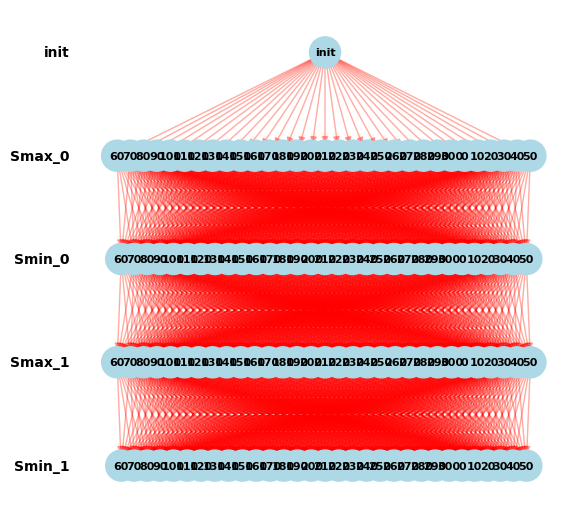

In [76]:
ant_colony = AntColony(flags, config)
ant_colony.plot_graph()